# Shallow classification for separating songs vs calls

## workflow:
1. select detections of species across dataset / stratification levels
- select 2-5x more clips than you plan to review in TDL, so that you still have enough after filtering out calls
2. select a random subset (ideally, stratified by point) of clips and annotate for song vs call
(not shown in this notebook bc in this case Brooke had already created some labels; I used labels from 20% of points for training and 80% for validation)
- eg, 200-500 clips total
- rapidly annotate with a binary label for "song" (or whatever the desired sound type is) in a notebook or in Dipper
- its ok to go fast and leave some clips as 'uncertain' or have a few wrong labels
2. embed all detections using Perch2 (works better than other foundation models for shallow classification)
3. train a shallow classifier on your annotations
- exclude any clips labeled 'uncertain' from train/validation
- use 80-90% of labels for training (I used 80% of _points_ for validation here just to demonstrate that the classifier generalizes very well)
4. apply the shallow classifier to all detections
5. filter the detections by the shallow classifier's score to retain songs and remove other sound types

In [1]:
import plot_utils # pip install plotly, anywidget
import pandas as pd
import bioacoustics_model_zoo as bmz
import torch

from sklearn.model_selection import train_test_split
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit

2026-01-08 14:43:51.577683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/sml161/miniconda3/envs/perch2/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/sml161/miniconda3/envs/perch2/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations 

select an embedding model from the bioacoustics model zoo

In [2]:
embedder = bmz.Perch2()

/home/sml161/miniconda3/envs/perch2/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
I0000 00:00:1767901434.786268  160658 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22138 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1767901434.788942  160658 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22320 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
/home/sml161/miniconda3/envs/perch2/lib/python3.11/site-packages/opensoundscape/ml/cnn.py:599: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading aft

load detections

here, the detections already have some labels. 1 means song, 0 means not FISP, 'c' means call

our goal is to remove calls and only get the songs for review

In [7]:
from opensoundscape.data_selection import resample
train_clips=resample(pd.read_csv('/home/dah238/Kauai-Amakihi/Experiment4/train_set.csv', index_col=([0,1,2])), n_samples_per_class= 1267,random_state=0)
val_clips=pd.read_csv('/home/dah238/Kauai-Amakihi/Experiment4/valid_set.csv', index_col=([0,1,2]))
train_clips.KAAM_song.value_counts()

KAAM_song
True     1267
False    1267
Name: count, dtype: int64

In [8]:
train_clips.head()
len(train_clips)

2534

embed the samples with hawkears

Note: Perch2 takes about 30-75 seconds to get going but then runs quickly on the gpu

In [9]:
embs_train = embedder.embed(train_clips[[]], batch_size=32,num_workers=4)

  0%|          | 0/80 [00:00<?, ?it/s]

2026-01-08 14:45:44.164096: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fecc806dec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-08 14:45:44.164130: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2026-01-08 14:45:44.164135: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2026-01-08 14:45:44.605014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-08 14:45:44.662892: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2026-01-08 14:45:44.982965: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints

In [10]:
embs_val = embedder.embed(val_clips[[]], batch_size=32,num_workers=4)

  0%|          | 0/16 [00:00<?, ?it/s]

2026-01-08 14:47:42.661230: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-08 14:47:42.661292: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-08 14:47:42.661304: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-08 14:47:43.914095: I external/l

In [11]:
embs_train.shape

(2534, 1536)

In [12]:
type(embs_train)        # should be pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

In [13]:
# create and fit 1-layer MLP classifier on embeddings
clf = MLPClassifier(input_size=embs_train.shape[1], output_size=1, hidden_layer_sizes=())
y_train = train_clips['KAAM_song'].values.reshape(-1, 1).astype(float)
y_val   = val_clips['KAAM_song'].values.reshape(-1, 1).astype(float)
quick_fit(clf, train_features=embs_train.to_numpy(), train_labels=y_train,
          validation_features=embs_val.to_numpy() , validation_labels=y_val)

Epoch 100/1000, Loss: 0.2916014790534973, Val Loss: 1.4101024866104126
val AU ROC: 0.780
val MAP: 0.451
Epoch 200/1000, Loss: 0.22823263704776764, Val Loss: 1.66177237033844
val AU ROC: 0.774
val MAP: 0.434
Epoch 300/1000, Loss: 0.19742517173290253, Val Loss: 1.8020869493484497
val AU ROC: 0.770
val MAP: 0.430
Epoch 400/1000, Loss: 0.17664659023284912, Val Loss: 1.8968244791030884
val AU ROC: 0.767
val MAP: 0.430
Epoch 500/1000, Loss: 0.16073833405971527, Val Loss: 1.9650410413742065
val AU ROC: 0.766
val MAP: 0.426
Epoch 600/1000, Loss: 0.14778102934360504, Val Loss: 2.0157310962677
val AU ROC: 0.766
val MAP: 0.430
Epoch 700/1000, Loss: 0.136847123503685, Val Loss: 2.054652690887451
val AU ROC: 0.767
val MAP: 0.432
Epoch 800/1000, Loss: 0.1274048388004303, Val Loss: 2.0855462551116943
val AU ROC: 0.767
val MAP: 0.435
Epoch 900/1000, Loss: 0.11911226063966751, Val Loss: 2.1108264923095703
val AU ROC: 0.768
val MAP: 0.436
Epoch 1000/1000, Loss: 0.11173296719789505, Val Loss: 2.132073402

In [ ]:
# save classifier weights
# torch.save(clf.state_dict(),'fisp_song_classifier_1layer.pth')

In [ ]:
# to reload the classifier in another script/notebook:
if False:
    clf = MLPClassifier(input_size=embs.shape[1], output_size=1, hidden_layer_sizes=())
    clf.load_state_dict(torch.load('fisp_song_classifier_1layer.pth'))

NameError: name 'embs' is not defined

In [14]:
# make "KAAM_song" predictions on all clips by applying classifier to embeddings
val_clips['KAAM_song_score'] = clf(torch.tensor(embs_val.values,dtype=torch.float32)).detach().numpy()[:,0]
val_clips

KAAM_song  \
file                                               start_time end_time              
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 93.0       96.0           True   
                                                   147.0      150.0          True   
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 78.0       81.0           True   
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 102.0      105.0          True   
                                                   108.0      111.0          True   
...                                                                           ...   
/media/kiwi/datasets/finalized/kaua2024a/PUAI_O... 150.0      153.0         False   
                                                   165.0      168.0         False   
                                                   171.0      174.0         False   
/media/kiwi/datasets/finalized/kaua2024a/PUAI_O... 9.0        12.0          False   
                                                   12.0       15.0          False   

                                                                        KAAM_song_score  
file                                               start_time end_time                   
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 93.0       96.0             5.216919  
                                                   147.0      150.0            6.329844  
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 78.0       81.0             4.730556  
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 102.0      105.0            3.426861  
                                                   108.0      111.0            4.613946  
...                                                                                 ...  
/media/kiwi/datasets/finalized/kaua2024a/PUAI_O... 150.0      153.0            2.163281  
                                                   165.0      168.0            2.148843  
                                                   171.0      174.0            1.190071  
/media/kiwi/datasets/finalized/kaua2024a/PUAI_O... 9.0        12.0             1.175579  
                                                   12.0       15.0             1.586937  

[504 rows x 2 columns]

In [15]:
# filter clips to those with high song score
song_clips = val_clips[val_clips['KAAM_song_score']>0]
song_clips

KAAM_song  \
file                                               start_time end_time              
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 93.0       96.0           True   
                                                   147.0      150.0          True   
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 78.0       81.0           True   
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 102.0      105.0          True   
                                                   108.0      111.0          True   
...                                                                           ...   
/media/kiwi/datasets/finalized/kaua2024a/PUAI_O... 150.0      153.0         False   
                                                   165.0      168.0         False   
                                                   171.0      174.0         False   
/media/kiwi/datasets/finalized/kaua2024a/PUAI_O... 9.0        12.0          False   
                                                   12.0       15.0          False   

                                                                        KAAM_song_score  
file                                               start_time end_time                   
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 93.0       96.0             5.216919  
                                                   147.0      150.0            6.329844  
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 78.0       81.0             4.730556  
/media/kiwi/datasets/finalized/kaua2024a/AKEK_g... 102.0      105.0            3.426861  
                                                   108.0      111.0            4.613946  
...                                                                                 ...  
/media/kiwi/datasets/finalized/kaua2024a/PUAI_O... 150.0      153.0            2.163281  
                                                   165.0      168.0            2.148843  
                                                   171.0      174.0            1.190071  
/media/kiwi/datasets/finalized/kaua2024a/PUAI_O... 9.0        12.0             1.175579  
                                                   12.0       15.0             1.586937  

[391 rows x 2 columns]

## Optional visualization

In [16]:
#plot_utils
# # requires plotly: pip install plotly
# from plot_utils import inspect
from opensoundscape import Audio, Spectrogram


import plotly.express as px
import plotly.graph_objects as go
from IPython.display import clear_output, display
import io
import base64
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from scipy.io import wavfile
from opensoundscape import Audio, Spectrogram


def plot_row(row):
    center_t = (row.start_time + row.end_time) / 2
    a = Audio.from_file(row.file, offset=center_t - 0.25, duration=0.5)
    s = Spectrogram.from_audio(a).bandpass(0, 3000)
    a.show_widget()
    s.plot()


def inspect(
    rows, dur=None, N=20, bandpass_range=None, dB_range=[-100, -20], cmap="Greys"
):
    rows = rows.sample(min(N, len(rows)))

    cells = []

    for _, row in rows.iterrows():
        if dur is None:
            start = row.start_time
            dur = row.end_time - row.start_time
        else:
            center_t = (row.start_time + row.end_time) / 2
            start = max(0, center_t - dur / 2)

        a = Audio.from_file(
            row.file,
            offset=start,
            duration=dur,
            out_of_bounds_mode="ignore",
        ).normalize()

        s = Spectrogram.from_audio(a)
        if bandpass_range is not None:
            s = s.bandpass(*bandpass_range)

        # --- spectrogram array ---
        spec = s.spectrogram  # (freq, time)

        spec = np.clip(spec, a_min=dB_range[0], a_max=dB_range[1])

        # --- render spectrogram to PNG ---
        fig, ax = plt.subplots(figsize=(2.2, 2.2))
        ax.imshow(
            spec,
            origin="lower",
            aspect="auto",
            cmap=cmap,
        )
        ax.axis("off")

        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
        plt.close(fig)

        img_b64 = base64.b64encode(buf.getvalue()).decode()

        # --- audio → WAV bytes ---
        wav_buf = io.BytesIO()

        samples = a.samples
        # if samples.ndim > 1:
        #     samples = samples.mean(axis=0)

        # normalize safely to int16
        samples = samples / max(1e-9, np.max(np.abs(samples)))
        samples_int16 = (samples * 32767).astype(np.int16)

        wavfile.write(wav_buf, a.sample_rate, samples_int16)

        audio_b64 = base64.b64encode(wav_buf.getvalue()).decode()

        cells.append(
            f"""
            <div class="cell">
                <img src="data:image/png;base64,{img_b64}"
                     onclick="this.nextElementSibling.play()"/>
                <audio src="data:audio/wav;base64,{audio_b64}"></audio>
            </div>
            """
        )

    html = f"""
    <style>
    .grid {{
        display: grid;
        grid-template-columns: repeat(auto-fill, minmax(140px, 1fr));
        gap: 10px;
    }}
    .cell {{
        cursor: pointer;
        border-radius: 6px;
        overflow: hidden;
        box-shadow: 0 2px 6px rgba(0,0,0,0.15);
        transition: transform 0.1s ease;
    }}
    .cell:hover {{
        transform: scale(1.03);
    }}
    .cell img {{
        width: 100%;
        display: block;
    }}
    </style>

    <div class="grid">
        {''.join(cells)}
    </div>
    """

    display(HTML(html))


import ipywidgets as widgets
from IPython.display import display

def get_selected_row_ids(fw):
    row_ids = []

    for tr in fw.data:
        if tr.selectedpoints is None:
            continue

        pts = np.asarray(tr.selectedpoints, dtype=int)
        row_ids.extend(tr.customdata[pts, 0])

    return np.unique(row_ids).astype(int)

def explore_features(
    df,
    x_col="x",
    y_col="y",
    color_col=None,
    symbol_col=None,
    size_col=None,
    hover_name_col=None,
    duration=0.5,
    N=12,
    dB_range=[-100, -20],
    bandpass_range=None,
    spec_window_samples=512,
):

    fig_out = widgets.Output()
    inspect_out = widgets.Output()

    df = df.copy()
    df["_row_id"] = np.arange(len(df))
    df["x"] = df[x_col]
    df["y"] = df[y_col]

    fig = px.scatter(
        df,
        x="x",
        y="y",
        color=color_col,
        hover_name=hover_name_col,
        symbol=symbol_col,
        size=size_col,
        opacity=0.8,
        custom_data=["_row_id"],
    )

    fw = go.FigureWidget(fig)
    # fw.selected_row_ids = np.array([], dtype=int)

    def on_select(trace, points, selector):
        # Only handle box selections
        if not hasattr(selector, "xrange"):
            return

        # xmin, xmax = selector.xrange
        # ymin, ymax = selector.yrange

        # selected = df[
        #     (df["x"] >= xmin)
        #     & (df["x"] <= xmax)
        #     & (df["y"] >= ymin)
        #     & (df["y"] <= ymax)
        # ]
        row_ids = []
        for tr in fw.data:
            # skip if trace is not visible

            if tr.selectedpoints is None:
                continue

            # selectedpoints are trace-local indices
            tr_points = np.asarray(tr.selectedpoints, dtype=int)

            # map to row ids via customdata
            tr_row_ids = tr.customdata[tr_points, 0]
            row_ids.extend(tr_row_ids)

        # fw.selected_row_ids = np.array(row_ids)

        row_ids = np.unique(row_ids).astype(int)
        if len(row_ids) == 0:
            return
        selected = df.iloc[row_ids]

        with inspect_out:
            inspect_out.clear_output(wait=True)
            print(f"{len(selected)} points selected")

            inspect(
                selected,
                dur=duration,
                N=N,
                bandpass_range=bandpass_range,
                dB_range=dB_range,
                cmap="Greys",
            )

    # Attach to ONE trace intentionally
    fw.data[0].on_selection(on_select)
    # for tr in fw.data:
    #     tr.on_selection(on_select)

    with fig_out:
        display(fw)

    display(fig_out, inspect_out)

    return fw

def make_label_buttons(fw, df, label_col="label"):
    btn0 = widgets.Button(
        description="Label selected = 0",
        button_style="danger",
        icon="times",
    )

    btn1 = widgets.Button(
        description="Label selected = 1",
        button_style="success",
        icon="check",
    )

    out = widgets.Output()

    def apply_label(label):
        with out:
            out.clear_output(wait=True)

            idx = get_selected_row_ids(fw)

            if len(idx) == 0:
                print("No points selected")
                return

            df.loc[idx, label_col] = label
            print(f"Labeled {len(idx)} points as {label}")

    btn0.on_click(lambda b: apply_label(0))
    btn1.on_click(lambda b: apply_label(1))

    display(widgets.HBox([btn0, btn1]), out)


import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
def explore_histogram(
    df,
    value_col,
    label_col,
    positive_value=1,
    negative_value=0,
    bins=30,
    sample_n=6,
    inspect_fn=None,
):

    # --- Widgets ---
    fig_out = widgets.Output()
    status = widgets.Output()

    show_pos = widgets.ToggleButton(
        description="Toggle Positives",
        value=True,
        button_style="success",

    )

    # grey for negatives
    show_neg = widgets.ToggleButton( 
        description="Toggle Negatives",
        value=True,
        button_style="",
    )

    sample_btn = widgets.Button(
        description="Inspect from visible",
        button_style="info",
    )

    # --- Figure ---
    fw = go.FigureWidget()

    df_pos = df[df[label_col] == positive_value]
    df_neg = df[df[label_col] == negative_value]

    fw.add_histogram(
        x=df_pos[value_col],
        nbinsx=bins,
        name="Positive",
        opacity=0.6,
        marker_color="green",
    )

    fw.add_histogram(
        x=df_neg[value_col],
        nbinsx=bins,
        name="Negative",
        opacity=0.6,
        marker_color="lightgrey",
    )

    fw.update_layout(
        barmode="overlay",
        dragmode="zoom",
        width=900,
        height=450,
    )

    # --- Logic ---
    def get_visible_range():
        r = fw.layout.xaxis.range
        if r is None:
            return None
        return float(r[0]), float(r[1])

    def get_selected_rows():
        r = get_visible_range()
        lo, hi = r if r else (df[value_col].min(), df[value_col].max())

        mask = (df[value_col] >= lo) & (df[value_col] <= hi)

        if show_pos.value and not show_neg.value:
            mask &= df[label_col] == positive_value
        elif show_neg.value and not show_pos.value:
            mask &= df[label_col] == negative_value

        return df[mask]

    def update_visibility(change=None):
        fw.data[0].visible = show_pos.value
        fw.data[1].visible = show_neg.value

    def on_sample(b):
        with status:
            status.clear_output(wait=True)
            sel = get_selected_rows()
            if len(sel) == 0:
                print("No samples selected")
                return
            sampled = sel.sample(min(sample_n, len(sel)))
            print(f"Inspecting {len(sampled)} samples")
            if inspect_fn:
                inspect_fn(sampled)

    show_pos.observe(update_visibility, names="value")
    show_neg.observe(update_visibility, names="value")
    sample_btn.on_click(on_sample)

    # --- Assemble UI ---
    controls = widgets.HBox([show_neg,show_pos,sample_btn])
    ui = widgets.VBox([fig_out, controls, status])

    # attach figure AFTER container exists
    fig_out.append_display_data(fw)

    return ui, fw


In [17]:
# show interactive histogram 
ui,fw=explore_histogram(val_clips.reset_index(),'KAAM_song_score',label_col='KAAM_song',inspect_fn=lambda rows: plot_utils.inspect(rows, dur=2),)
ui

### inspect random clips from subsets

clips predicted to have song:


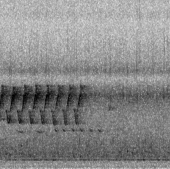
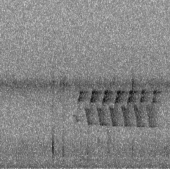
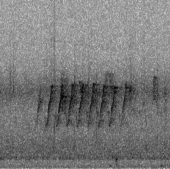
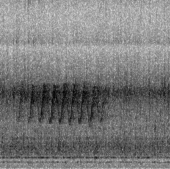
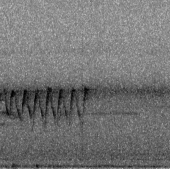
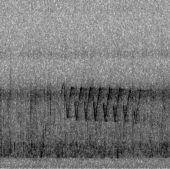
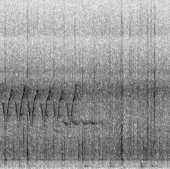
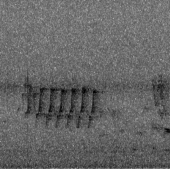
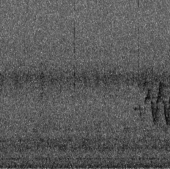
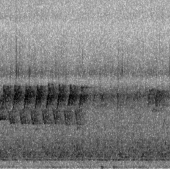
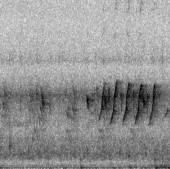
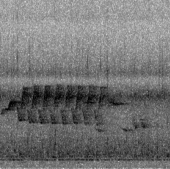
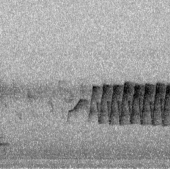
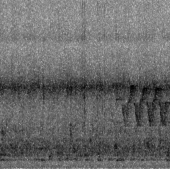
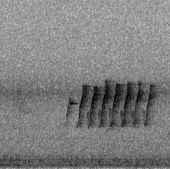
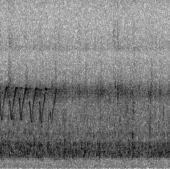

In [18]:
plot_utils.inspect(val_clips[val_clips.KAAM_song==1].reset_index(),N=16)

clips predicted to not have song:


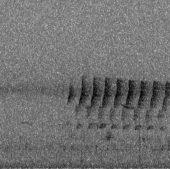
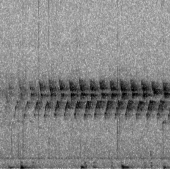
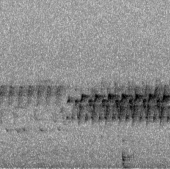
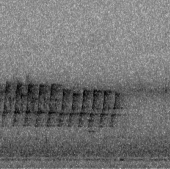
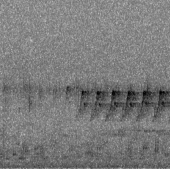
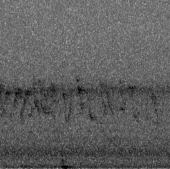
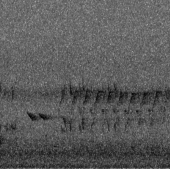
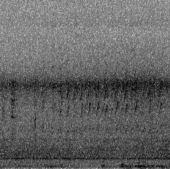
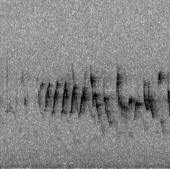
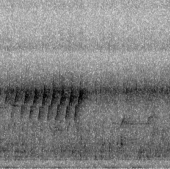
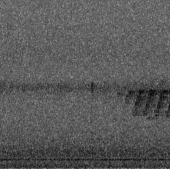
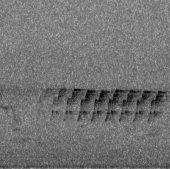
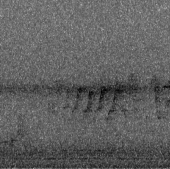
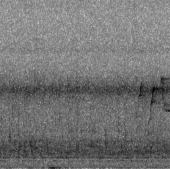
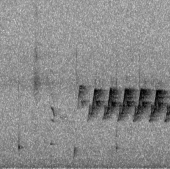
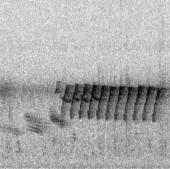

In [19]:
plot_utils.inspect(val_clips[val_clips.KAAM_song==0].reset_index(),N=16)